<a href="https://colab.research.google.com/github/Ritz0820/MYDAILYWORK/blob/main/ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import re

from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BASE_DIR='./sample_data/flickr8k'
IMAGE_DIR='/content/drive/MyDrive/colabdata'
WORKING_DIR='/content/working'


Extract Image Features

In [ ]:
#load vgg16 model
model=VGG16()
#restructure the model
model= Model(inputs=model.inputs,outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
#Extract features from image
features={}
directory=os.path.join(IMAGE_DIR,'/content/drive/MyDrive/colabdata/Images')

for img_name in tqdm(os.listdir(directory)):
  img_path=directory+'/'+img_name
  image=load_img(img_path,target_size=(224,224))
  #convert image pixels to numpy array
  image=img_to_array(image)
  #Reshape data for model
  image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
  #preprocess image for vgg
  image=preprocess_input(image)
  #extract features
  feature=model.predict(image,verbose=0)
  #get image ID
  image_id=img_name.split('.')[0]
  #store feature
  features[image_id]=feature


In [ ]:
pickle.dump(features,open(os.path.join(WORKING_DIR,'features_pk1'),'wb'))

In [ ]:
with open(os.path.join(WORKING_DIR,'/content/working/features (1).pk1'),'rb') as f:
  features=pickle.load(f)

Load the captions data

In [4]:
with open(os.path.join(BASE_DIR,'/content/sample_data/flickr8k/captions.txt'),'r') as f:
  next(f)
  captions_doc=f.read()

In [5]:
from tqdm import tqdm

# Initialize mapping dictionary
mapping = {}

# Process lines
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma
    tokens = line.split(',')

    # Ensure there are exactly two tokens (image_id and caption)
    if len(tokens) < 2:
        continue

    image_id, caption = tokens[0], tokens[1]

    # Remove extension from image ID
    image_id = image_id.split('.')[0]

    # Remove leading/trailing spaces and join caption tokens
    caption = caption.strip()

    # Create list if needed
    if image_id not in mapping:
        mapping[image_id] = []

    # Append the caption to the list for this image_id
    mapping[image_id].append(caption)

# Check the created mapping
for key, value in mapping.items():
    print(f'{key}: {value}')

100%|██████████| 40456/40456 [00:00<00:00, 630179.91it/s]


Streaming output truncated to the last 5000 lines.
2844747252_64567cf14a: ['A small dog watches two big dogs playing rough in a field .', 'Three dogs are playing with a yellow ball in a grassy field .', 'Three dogs play together in the field .', 'Two dogs are fighting over a toy and another dog is chasing them .', 'Two dogs play together and another runs after in a field .']
2844846111_8c1cbfc75d: ['a man climber a large rock without any gear while his friends watch', 'A person climbing a rock while others are standing around and watching .', 'A person hangs off a large rock as other people watch .', 'A rock climber hangs from a ledge while others look on .', 'Man dangling from rock as spectators watch']
2844963839_ff09cdb81f: ['a group of football players huddled together in the middle of the field .', 'A group of football players wearing orange and blue uniforms gather together on the field .', 'Football players in blue and orange uniforms are huddled together and hugging each other 

In [ ]:
len(mapping)

8091

In [6]:
import re

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            # Convert to lowercase
            caption = caption.lower()
            # Remove special characters, but keep spaces
            caption = re.sub(r'[^a-z\s]', '', caption)
            # Remove extra spaces
            caption = re.sub(r'\s+', ' ', caption).strip()
            # Check if caption has content after cleaning
            if caption:
                # Add start and end tags to the caption
                caption = '<startseq> ' + caption + ' <endseq>'
            else:
                # If caption is empty after cleaning, add just the start and end tags
                caption = '<startseq> <endseq>'
            captions[i] = caption
    return mapping

In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
clean(mapping)

In [9]:
mapping['1000268201_693b08cb0e']

['<startseq> a child in a pink dress is climbing up a set of stairs in an entry way <endseq>',
 '<startseq> a girl going into a wooden building <endseq>',
 '<startseq> a little girl climbing into a wooden playhouse <endseq>',
 '<startseq> a little girl climbing the stairs to her playhouse <endseq>',
 '<startseq> a little girl in a pink dress going into a wooden cabin <endseq>']

In [11]:
all_captions=[]
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [12]:
all_captions[:10]

['<startseq> a child in a pink dress is climbing up a set of stairs in an entry way <endseq>',
 '<startseq> a girl going into a wooden building <endseq>',
 '<startseq> a little girl climbing into a wooden playhouse <endseq>',
 '<startseq> a little girl climbing the stairs to her playhouse <endseq>',
 '<startseq> a little girl in a pink dress going into a wooden cabin <endseq>',
 '<startseq> a black dog and a spotted dog are fighting <endseq>',
 '<startseq> a black dog and a tricolored dog playing with each other on the road <endseq>',
 '<startseq> a black dog and a white dog with brown spots are staring at each other in the street <endseq>',
 '<startseq> two dogs of different breeds looking at each other on the road <endseq>',
 '<startseq> two dogs on pavement moving toward each other <endseq>']

In [ ]:
#tokenizing text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [ ]:
vocab_size

8586

In [ ]:
#get max length of caption
max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

**Train-Test-Split**

In [ ]:
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.90)
train=image_ids[:split]
test=image_ids[split:]


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        X1, X2, y = list(), list(), list()  # Initialize lists for storing input-output pairs
        n = 0

        # Iterate over all data keys
        for key in data_keys:
            captions = mapping[key]

            # Process each caption for the current key
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]  # Convert caption to sequence of integers

                # Create input-output pairs
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]  # Input sequence is the portion of the caption up to index i

                    # Pad input sequence to the maximum length
                    in_seq = pad_sequences([in_seq], maxlen=max_length,padding='post')[0]

                    # One-hot encode the output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append the features and sequences to the list
                    X1.append(features[key][0])  # Image features
                    X2.append(in_seq)            # Padded input sequence
                    y.append(out_seq)            # One-hot encoded output sequence

            n += 1

            # If batch size is reached, yield the batch and reset lists
            if n == batch_size:
                yield (np.array(X1), np.array(X2)), np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0

**MODEL CREATION**

In [ ]:
!pip install pydot graphviz

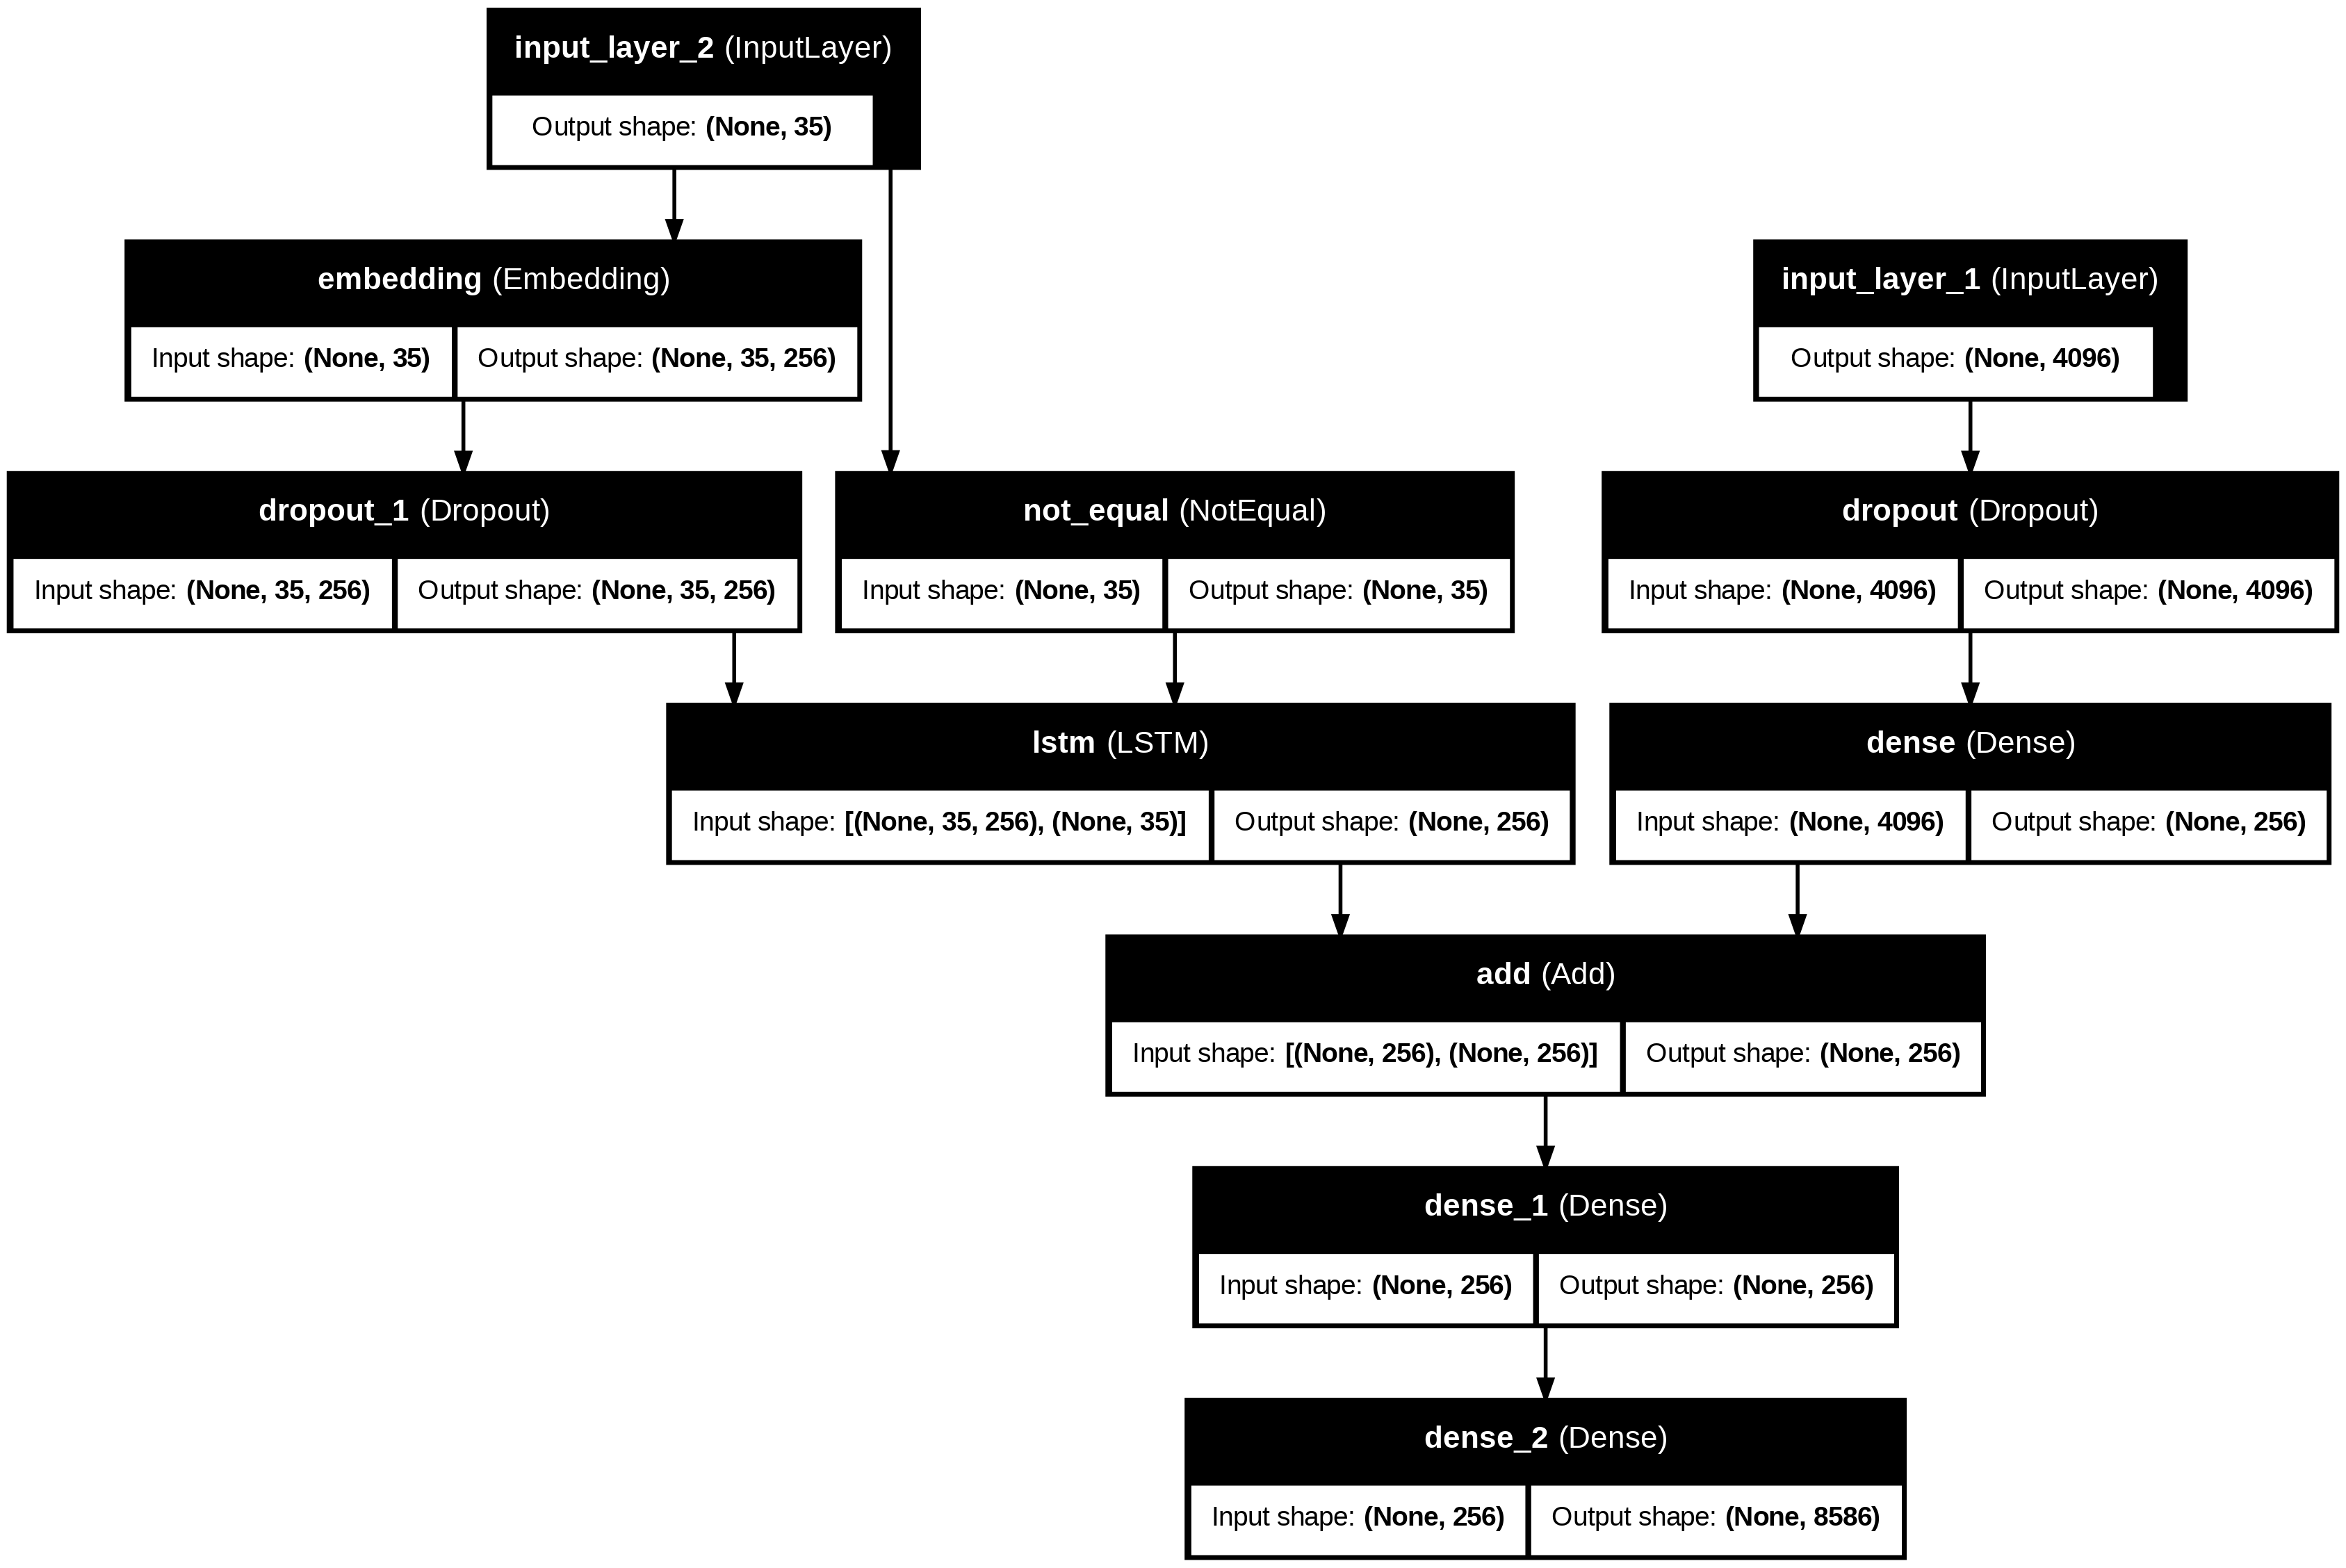

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# Image feature extraction layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature extraction layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)

# Add recurrent_dropout to LSTM to avoid CuDNN usage
se3 = LSTM(256, recurrent_dropout=0.2)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Define parameters
epochs = 15
batch_size = 32
steps = len(train) // batch_size

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

    # Fit the model for one epoch
    model.fit(
        generator,
        epochs=1,
        steps_per_epoch=steps,
        verbose=1
    )


Epoch 1/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 97s 386ms/step - loss: 5.3058
Epoch 2/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 90s 395ms/step - loss: 3.5372
Epoch 3/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 88s 387ms/step - loss: 3.1171
Epoch 4/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 89s 390ms/step - loss: 2.8717
Epoch 5/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 89s 391ms/step - loss: 2.6951
Epoch 6/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 89s 393ms/step - loss: 2.5621
Epoch 7/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 88s 389ms/step - loss: 2.4663
Epoch 8/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 90s 395ms/step - loss: 2.3884
Epoch 9/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 89s 391ms/step - loss: 2.3253
Epoch 10/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 92s 403ms/step - loss: 2.2641
Epoch 11/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 90s 396ms/step - loss: 2.2124
Epoch 12/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 92s 407ms/step - loss: 2.1683
Epoch 13/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 89s 392ms/step - loss: 2.1308
Epoch 14/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 91s 401ms/step - loss: 2.0937
Epoch 15/15
227

In [ ]:
model.save('best_model.h5')

**Generate captions for the image **

In [ ]:
def idx_to_word(integer,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index==integer:
      return word
  return None

In [ ]:
#generate caption for an image
def predict_caption(model,image,tokenizer,max_length):
  in_text='<startseq>'
  #iterate over the max length of sequence
  for i in range(max_length):
    #encode input sentence
    sequence=tokenizer.texts_to_sequences([in_text])[0]
    sequence=pad_sequences([sequence],max_length)
    yhat=model.predict([image,sequence],verbose=0)
    #get index with high probability
    yhat=np.argmax(yhat)
    #convert index to word
    word=idx_to_word(yhat,tokenizer)
    #stop if word not found
    if word is None:
      break
    #append word as input for generating next word
    in_text+= " " + word
    #stop if we reach end tag
    if word == '<endseq>':
      break
  return in_text

In [ ]:
!pip install nltk
#Import the module containing the corpus_bleu function
from nltk.translate.bleu_score import corpus_bleu

#validate the test data
actual,predicted=list(),list()

for key in tqdm(test):
  #get actual caption
  captions=mapping[key]
  #predict the caption for image
  y_pred=predict_caption(model,features[key],tokenizer,max_length)
  #split into words
  actual_captions=[caption.split() for caption in captions]
  y_pred=y_pred.split()
  #append the list
  actual.append(actual_captions)
  predicted.append(y_pred)

#calculate BLEU score
print("BLEU-1: %f" %corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2: %f" %corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

**VISUALIZE THE RESULTS**

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
image_name= "1002674143_1b742ab4b8.jpg "
image_id=image_name.split('.')[0]
img_path=os.path.join(IMAGE_DIR, "/content/drive/MyDrive/colabdata/Images",image_name)
image=Image.open(img_path)
captions=mapping[image_id]
print('---------------------ACTUAL-----------------------')
for caption in captions:
  print(caption)
#predict the caption
y_pred=predict_caption(model,features[image_id],tokenizer,max_length)
print('---------------------PREDICTED---------------------')
print(y_pred)
plt.imshow(image)

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl in pink dress is lying on the side of the grass endseq


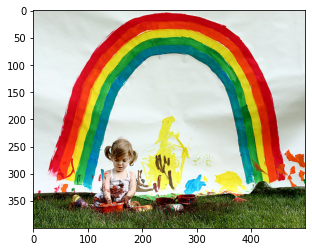

In [ ]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs play with each other in the grass endseq


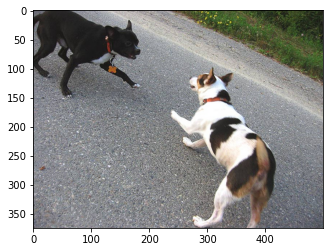

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq two people are hiking up snowy mountain endseq


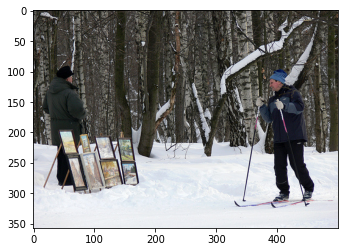

In [ ]:
generate_caption("101669240_b2d3e7f17b.jpg")